In [2]:
%load_ext autoreload
%autoreload 2

# Examining ChiX

## Imports

In [3]:
import ViennaRNA
from varnaapi import Structure
import os
import numpy as np

['java', '-cp', './VARNAv3-93.jar', 'fr.orsay.lri.varna.applications.VARNAcmd', '-sequenceDBN', 'ACACCGTCGCTTAAAGTGACGGCATAATAATAAAAAAATGAAATTCCTCTTTGACGGGCCAATAGCGATATTGGCCATTTTTTT', '-structureDBN', '...((((((((...)))))))).........(((((((((.....((........))(((((((....))))))))))))))))', '-o', '/tmp/tmpb5kfvec6.png', '-resolution', '10']


Output file: /tmp/tmpb5kfvec6.png



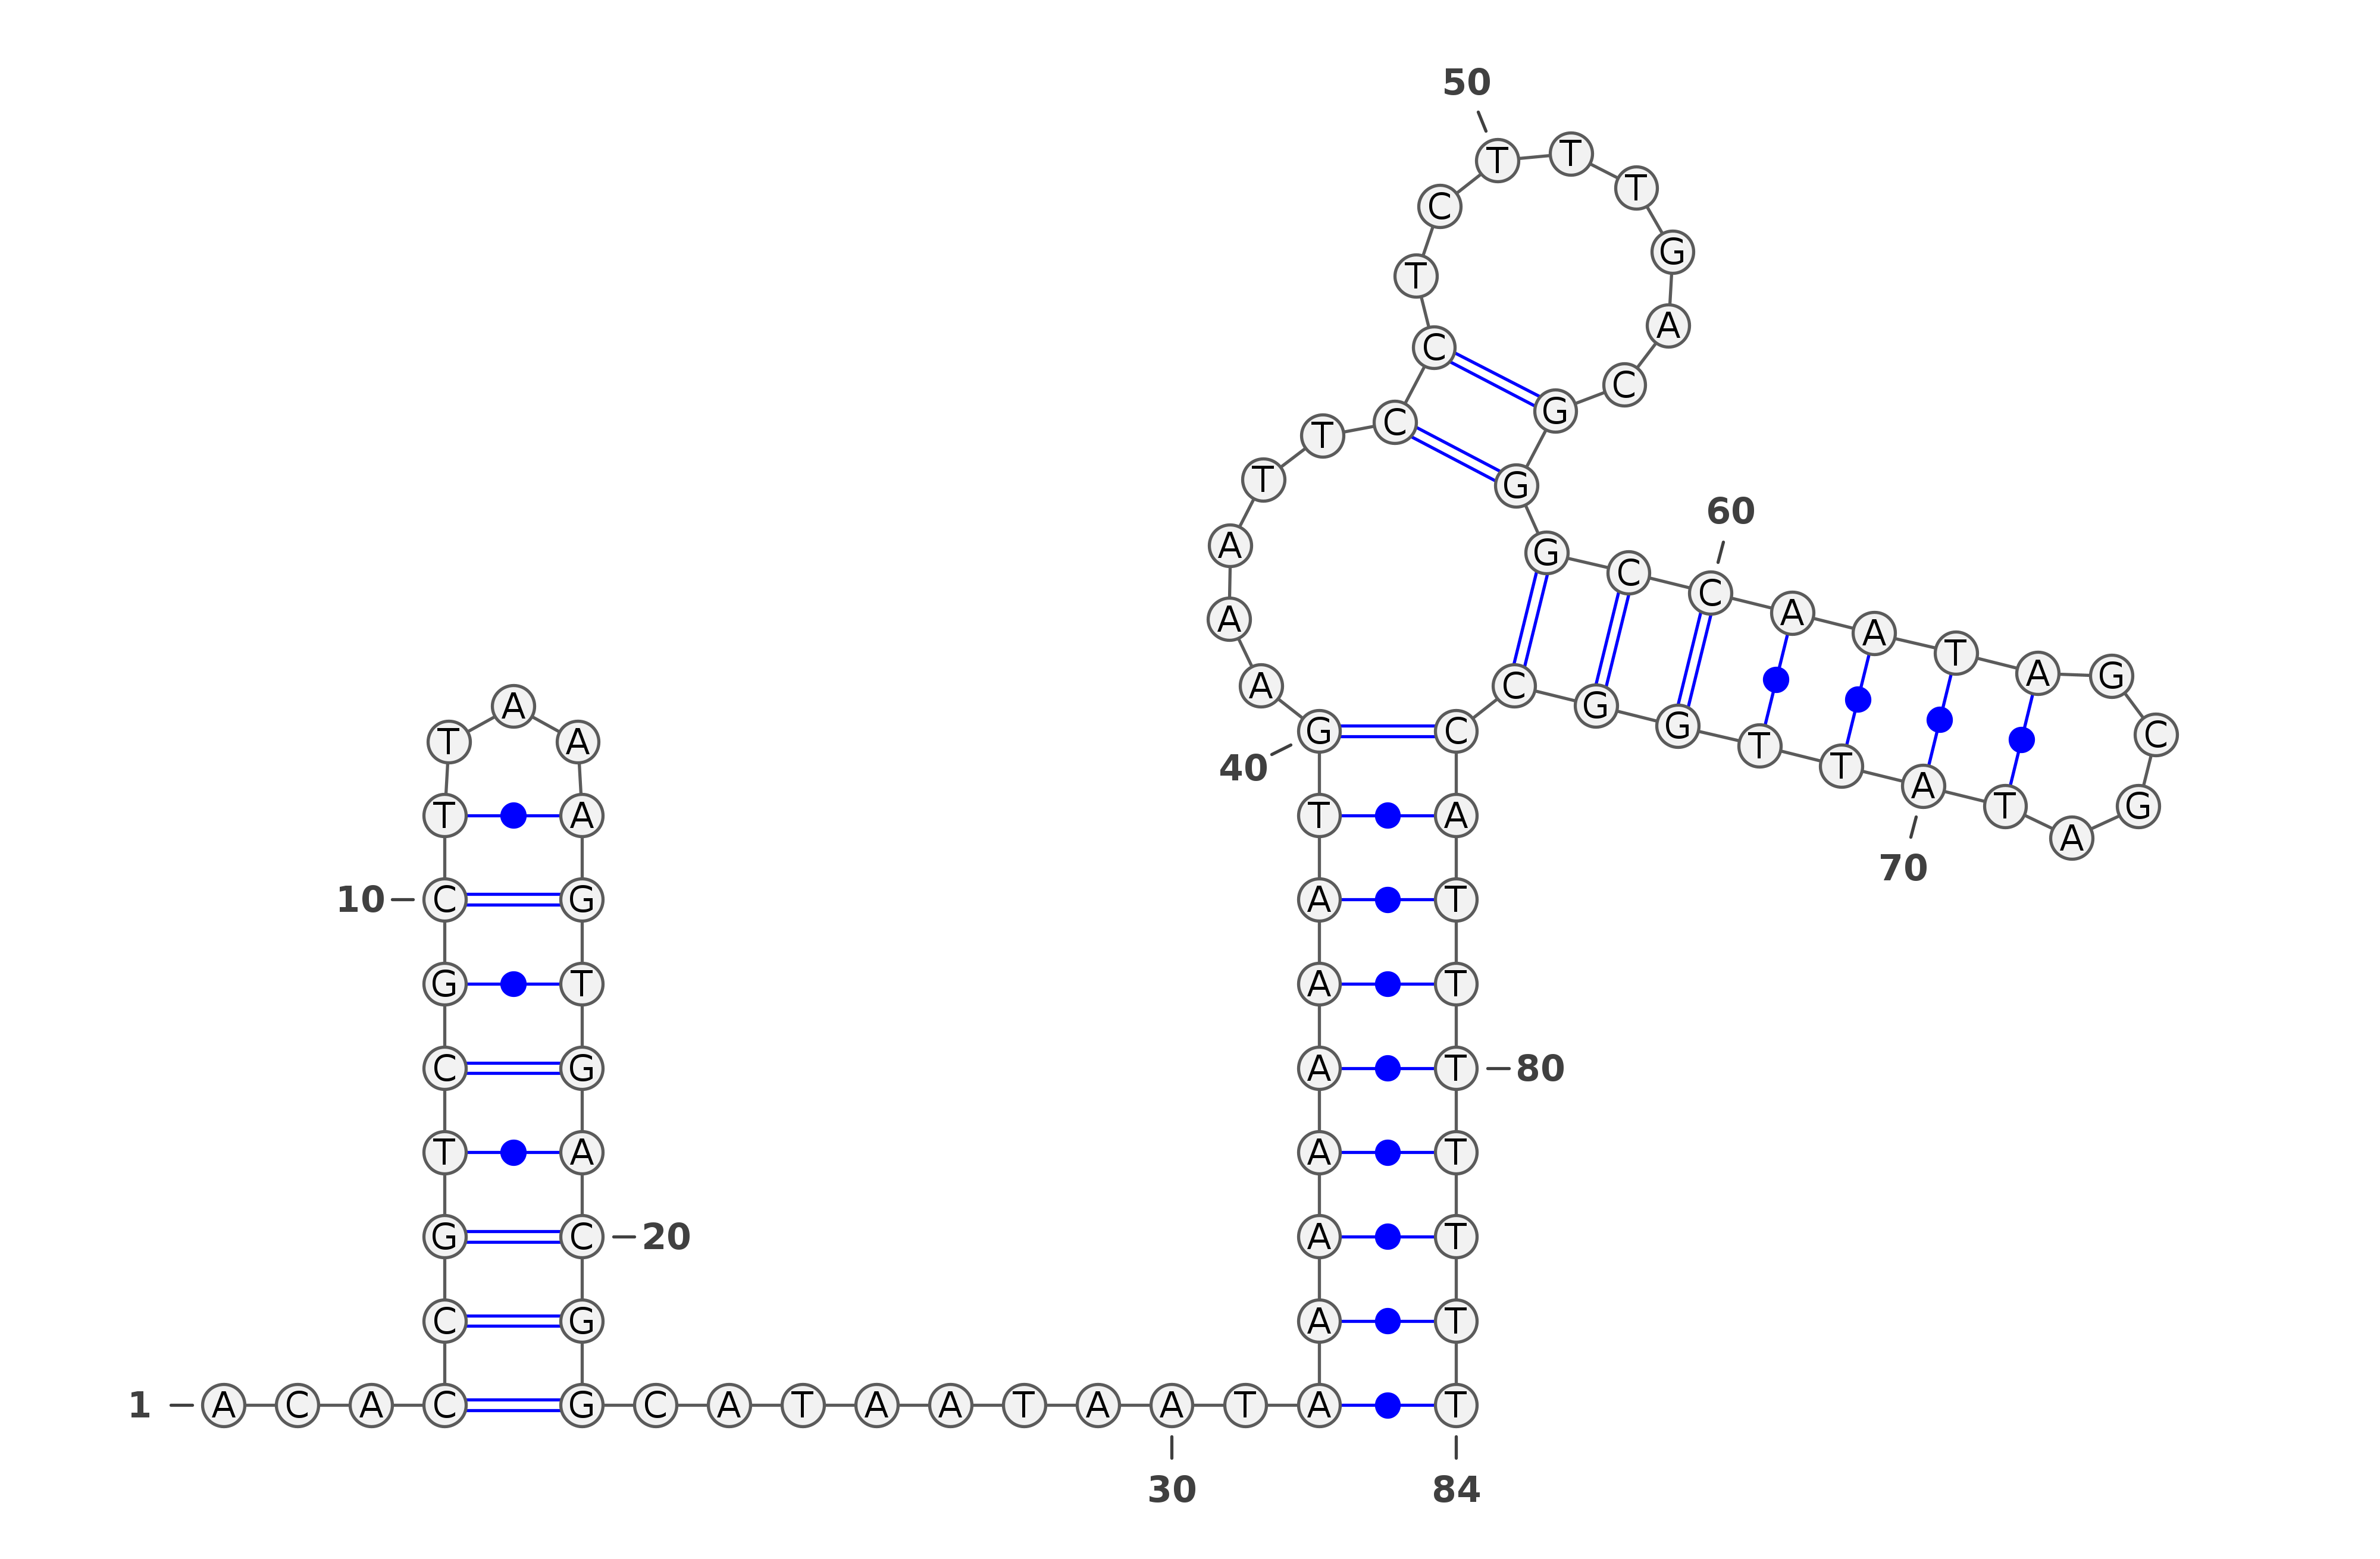

In [4]:
s = ''
# ChiX
seq = 'ACACCGTCGCTTAAAGTGACGGCATAATAATAAAAAAATGAAATTCCTCTTTGACGGGCCAATAGCGATATTGGCCATTTTTTT'
folded = ViennaRNA.fold(seq, s)
folded

v = Structure(structure=folded[0], sequence=seq)
v._params['resolution'] = 10
v.show()
# v.savefig("example.png", show=True)